In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm


In [24]:

if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

mps


In [25]:
path = "images/birds.png"
im = Image.open(path).convert("RGB")
im_tensor_cpu = to_tensor(im).to(device="cpu")
im_tensor_mps =to_tensor(im).to(device="mps") 
print(f"inital tensor size : {im_tensor_cpu.shape}")


max_dim = 250
_, H, W = im_tensor_mps.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_mps.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 164, 244])
rescaled tensor size : torch.Size([3, 168, 249])


In [26]:
          # dimension mini au coarse scale
N = 1
current_H, current_W = new_H, new_W
r = 4 / 3               # scaling factor (environ 1.333)
min_dim = 25  
# Calculer N tel que le coarse scale soit >= min_dim
while current_H >= min_dim and current_W >= min_dim:
    N += 1
    current_H = int(current_H / r)
    current_W = int(current_W / r)
N

8

In [27]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(1, N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / r), 1)
    new_w = max(int(w / r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


Number of scales N = 8
Scaling factor r = 1.333
Scale 0 : torch.Size([1, 3, 168, 249])


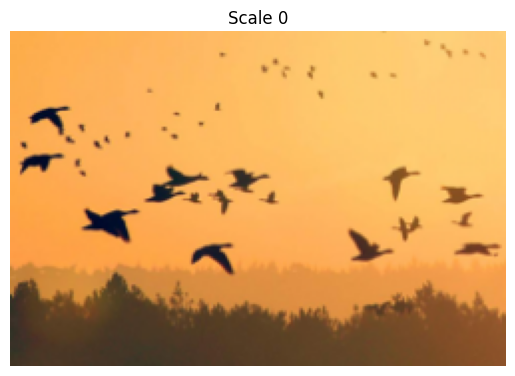

Scale 1 : torch.Size([1, 3, 126, 186])


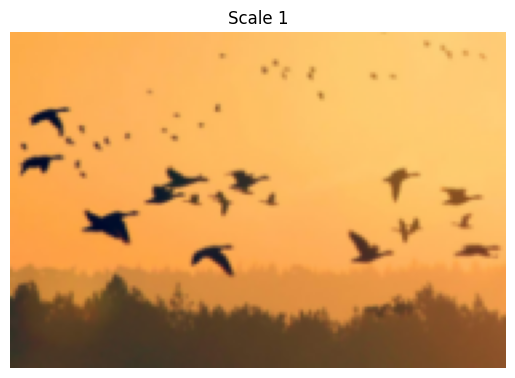

Scale 2 : torch.Size([1, 3, 94, 139])


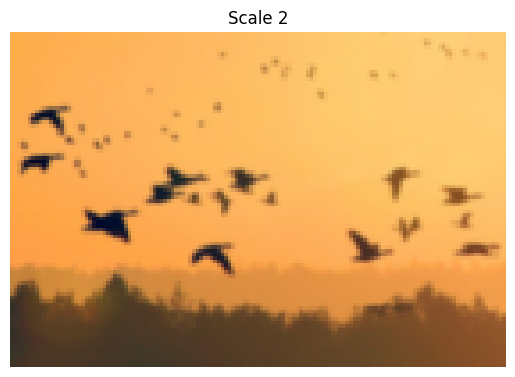

Scale 3 : torch.Size([1, 3, 70, 104])


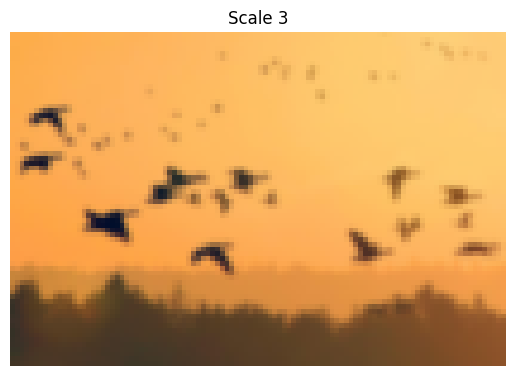

Scale 4 : torch.Size([1, 3, 52, 78])


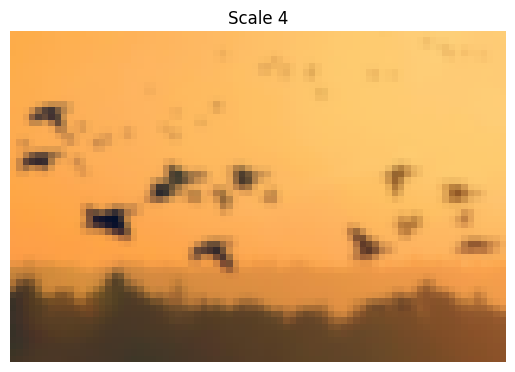

Scale 5 : torch.Size([1, 3, 39, 58])


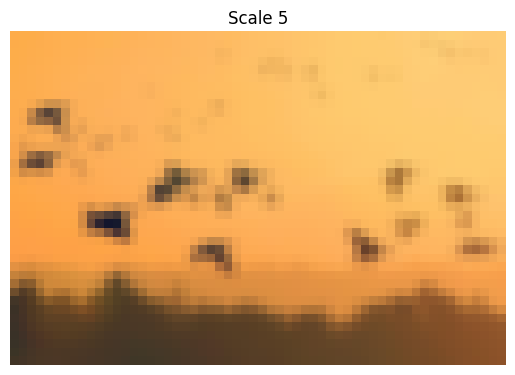

Scale 6 : torch.Size([1, 3, 29, 43])


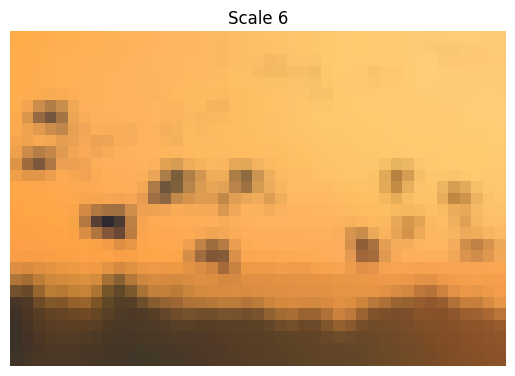

Scale 7 : torch.Size([1, 3, 21, 32])


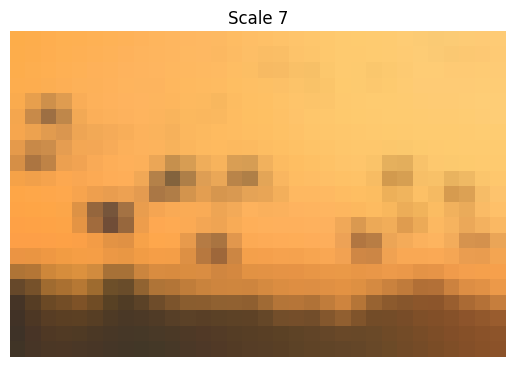

In [28]:
def pil_from_minus1to1(t):
    """
    Convertit un tenseur [-1,1] (CHW ou 1,C,H,W) en PIL Image.
    """
    t = t.squeeze(0) if t.dim() == 4 else t          # B×C×H×W → C×H×W
    t = ((t.clamp(-1, 1) + 1) / 2)                   # [-1,1] → [0,1]
    return to_pil_image(t.cpu())



print(f"Number of scales N = {N}")
print(f"Scaling factor r = {r:.3f}")
for i, im_scale in enumerate(scales):
    print(f"Scale {i} : {im_scale.shape}")
    plt.imshow(pil_from_minus1to1(im_scale.squeeze().cpu()))
    plt.axis('off')
    plt.title(f"Scale {i}")
    plt.show()


In [29]:
# ---------------------------------------------------------------------------
# 0. imports supplémentaires
# ---------------------------------------------------------------------------
import torchvision.models as models
import torchvision.transforms.functional as TF

# ---------------------------------------------------------------------------
# 1. extracteur = Inception-V3 tronqué (2048 d après pool)
#    → pas de grad demandé : on le gèle
# ---------------------------------------------------------------------------
inception = models.inception_v3(weights="IMAGENET1K_V1",
                                transform_input=False)
inception.fc = torch.nn.Identity()          # on garde les 2048 features
inception.eval().requires_grad_(False).to(device)

@torch.no_grad()
def inception_features(img_bchw: torch.Tensor) -> torch.Tensor:
    """
    img_bchw : [-1,1] → convertir en [0,1] puis normaliser
    retourne un tensor (B,2048)
    """
    x = (img_bchw + 1) / 2                  # [-1,1] → [0,1]
    x = TF.resize(x, (299, 299), antialias=True)
    return inception(x).flatten(1)          # (B,2048)


In [30]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

In [31]:
class Discriminator(nn.Module):
    def __init__(self,n_hidden):
        
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(3, self.n_hidden, kernel_size=3, padding=1),  
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, 1, 3, padding=1)  
        )
    
    def forward(self,input):
        return self.main(input)

In [32]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

In [33]:
netD_visu = Discriminator(n_hidden=32).to("cpu")
torchsummary.summary(netD_visu, input_size=input_size_visu,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 1, 1024, 1024]             289
Total params: 29,185
Trainable params: 

+ Générations des generateurs/discriminateurs

In [34]:
# ---------------------------------------------------------------------------
# 2. loss closed-form (Newton–Schulz 8 iters)
# ---------------------------------------------------------------------------
def _covariance(feats, mean):
    f = feats - mean
    return f.T @ f / (feats.size(0) - 1)

def _sqrtm(A, n_iter: int = 8):
    # Newton–Schulz ; A supposée SPD déjà "whitened"
    Y = A / A.trace()
    I = torch.eye(A.size(0), device=A.device)
    Z = I.clone()
    for _ in range(n_iter):
        T  = 0.5 * (3*I - Z @ Y)
        Y, Z = Y @ T, T @ Z
    return Y * A.trace().sqrt()

def w2_gaussian_loss(f_real, f_fake, eps=1e-4, n_iter=4):
    mu_r, mu_f = f_real.mean(0), f_fake.mean(0)
    C_r = _covariance(f_real, mu_r) + eps * torch.eye(f_real.size(1), device=f_real.device)
    C_f = _covariance(f_fake, mu_f) + eps * torch.eye(f_fake.size(1), device=f_fake.device)
    # √m par Newton–Schulz (4 iters)
    Y = C_f @ C_r @ C_f
    tr = Y.trace()
    Y /= tr
    I  = torch.eye(Y.size(0), device=Y.device)
    Z  = I.clone()
    for _ in range(n_iter):
        T = 0.5 * (3*I - Z @ Y)
        Y, Z = Y @ T, T @ Z
    A = Y * tr.sqrt()
    return (mu_r - mu_f).pow(2).sum() + (C_r + C_f - 2*A).trace()


In [35]:
import math
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils
import matplotlib.pyplot as plt

###############################################################################
# 1.  Build a frozen VGG19 patch encoder (option A)
###############################################################################

def build_vgg_patch_encoder(device="cpu", truncate_at_relu="relu2_2"):
    """Return a small CNN that maps (N,3,p,p) → (N, D).

    Only the first blocks of VGG‑19 are kept and **frozen**.
    truncate_at_relu: one of "relu1_2", "relu2_2", "relu3_4".
    """
    full = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features

    # map layer name → index in torchvision VGG19 list
    _cuts = {"relu1_2": 4, "relu2_2": 9, "relu3_4": 18}
    if truncate_at_relu not in _cuts:
        raise ValueError(f"unknown cut {truncate_at_relu}; choose from {_cuts.keys()}")

    encoder = torch.nn.Sequential(*full[: _cuts[truncate_at_relu] + 1])  # +1 → include relu
    encoder.eval().to(device)
    encoder.requires_grad_(False)  # freeze
    return encoder

###############################################################################
# 2.  patch_features: extract + (optionally) visualise patches
###############################################################################

def patch_features(img_bchw: torch.Tensor,
                   patch_size: int = 11,
                   stride: int = 11,
                   encoder: torch.nn.Module | None = None,
                   viz: bool = False,
                   step: int = 0,
                   viz_every: int = 200,
                   n_viz: int = 25,
                   title: str = "patches") -> torch.Tensor:
    """Extract patch vectors and (optionally) show a tile of raw patches.

    If an encoder (e.g. frozen VGG) is supplied, its 4‑D output is *global‑average‑pooled*
    so that the returned tensor is 2‑D (N, D) — indispensable for the covariance.
    """
    B, C, H, W = img_bchw.shape

    # ------------------------------------------------------------- 1) UNFOLD
    patches = F.unfold(img_bchw, kernel_size=patch_size, stride=stride)
    patches = patches.permute(0, 2, 1).reshape(-1, C * patch_size * patch_size)  # (M, C·p²)

    # ------------------------------------------------------------- 2) ENCODER (optional)
    if encoder is not None:
        patches_img = patches.view(-1, 3, patch_size, patch_size)
        # ------------------------------------------------- VGG expects normalised [0,1] then (x-mean)/std
        x01  = (patches_img + 1) / 2  # scale to [0,1]
        mean = torch.tensor([0.485, 0.456, 0.406], device=patches_img.device).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225], device=patches_img.device).view(1,3,1,1)
        x01  = (x01 - mean) / std
        feat = encoder(x01)               # normalise → [0,1]
        # GAP if conv output still 4‑D
        if feat.ndim == 4:
            feat = feat.mean(dim=[-2, -1])                  # (N, D)
        patches = feat                                      # (M, D)

    # ------------------------------------------------------------- 3) VISUALISATION
    if viz and step % viz_every == 0 and encoder is None:
        with torch.no_grad():
            idx = torch.randperm(patches.size(0))[: n_viz]
            sel = patches[idx].view(-1, 3, patch_size, patch_size).cpu()
            nrow = int(math.sqrt(sel.size(0))) or 1
            grid = vutils.make_grid(sel, nrow=nrow, normalize=True, range=(-1, 1))
            plt.figure(figsize=(3, 3))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis("off")
            plt.title(f"{title} (step {step})")
            plt.show()
    elif viz and step % viz_every == 0 and encoder is not None:
        print("[INFO] patch_features: viz=True mais encodeur actif; pas d'affichage des pixels bruts.")

    return patches



In [36]:
hidden_lowest_dim = 32
Genarators = []
Discriminators = []

for i in range(len(scales)):
    r = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(r//4)).to(device))
    Discriminators.append(Discriminator(hidden_lowest_dim * 2**(r//4)).to(device))
    
Genarators.reverse()
Discriminators.reverse()

for gen in Genarators : 
     print(gen.n_hidden)
for dis in Discriminators:
     print(dis.n_hidden)


32
32
32
64
64
64
64
128
32
32
32
64
64
64
64
128


+ Boucle d'entrainement 

In [37]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


for G in Genarators:
    G.apply(weights_init)
for D in Discriminators:
    D.apply(weights_init)

coarse:   0%|          | 0/1500 [00:00<?, ?it/s]

[it 0000] adv=59.8  grad‖=4.67e+00
fake μ=0.075 σ=0.380


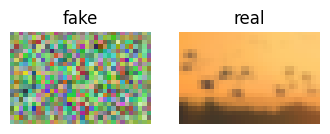

coarse:  13%|█▎        | 199/1500 [00:03<00:20, 63.37it/s]

[it 0200] adv=-325.4  grad‖=3.22e+01
fake μ=0.060 σ=0.932


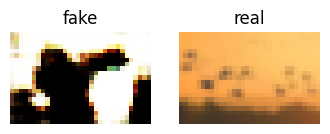

coarse:  26%|██▋       | 395/1500 [00:06<00:17, 63.88it/s]

[it 0400] adv=-452.7  grad‖=3.68e+01
fake μ=-0.073 σ=0.936


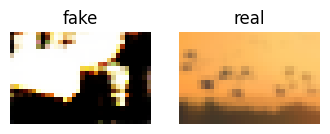

coarse:  40%|███▉      | 598/1500 [00:09<00:14, 63.77it/s]

[it 0600] adv=-289.1  grad‖=3.12e+01
fake μ=0.041 σ=0.954


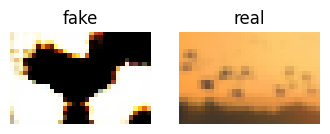

coarse:  53%|█████▎    | 794/1500 [00:12<00:11, 62.80it/s]

[it 0800] adv=-364.2  grad‖=3.39e+01
fake μ=0.020 σ=0.930


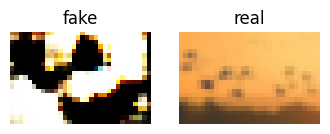

coarse:  67%|██████▋   | 998/1500 [00:16<00:07, 66.03it/s]

[it 1000] adv=-277.8  grad‖=3.16e+01
fake μ=-0.123 σ=0.945


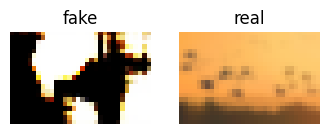

coarse:  80%|███████▉  | 1197/1500 [00:19<00:04, 65.95it/s]

[it 1200] adv=-456.6  grad‖=3.66e+01
fake μ=0.071 σ=0.963


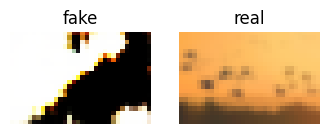

coarse:  93%|█████████▎| 1400/1500 [00:22<00:01, 65.70it/s]

[it 1400] adv=-315.7  grad‖=3.23e+01
fake μ=-0.015 σ=0.956


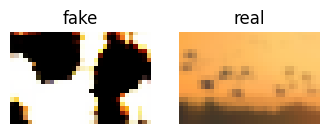

In [38]:
# --------------------------- one-scale debug loop --------------------------- #
import torch, torch.nn.functional as F, matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(0)

# -------------------------- hyper-params ---------------------------- #
lr            = 1e-4
iter_total    = 1500
patch_sz      = 7
stride        = 7
sigma_n_cur   = 0.1
alpha_rec     = 0.3
n_updates_G   = 2
viz_every     = 200
device        = device          # déjà défini via scales

# ------------------------ init réseau & opti ------------------------ #
current_res = N - 1                     # coarse only
Gk = Genarators[current_res].train()
opt_G = torch.optim.Adam(Gk.parameters(), lr=lr, betas=(0.5,0.999))

xk_real = scales[current_res].to(device)   # (1,C,H,W)
z_star  = torch.randn_like(xk_real)

# ----------------------------- loop -------------------------------- #
for it in tqdm(range(iter_total), desc='coarse', leave=False):

    prev_img = torch.zeros_like(xk_real)

    for _ in range(n_updates_G):
        opt_G.zero_grad()

        z    = torch.randn_like(prev_img) * sigma_n_cur
        fake = Gk(z + prev_img) + prev_img
        fake.retain_grad()                       # <- on garde ∂fake

        # W₂ sur patchs RGB bruts
        with torch.no_grad():
            f_real = patch_features(xk_real, patch_sz, stride,
                                    encoder=None, viz=False)
        f_fake = patch_features(fake, patch_sz, stride,
                                encoder=None, viz=False)
        adv_G  = w2_gaussian_loss(f_real, f_fake)

        # aucun terme de reco pour le debug
        adv_G.backward()
        opt_G.step()

    # ------------------------- debug ----------------------------- #
    if it % viz_every == 0:
        grad_norm = fake.grad.norm().item()
        print(f"[it {it:04d}] adv={adv_G.item():.1f}  grad‖={grad_norm:.2e}")
        print(f"fake μ={fake.mean():.3f} σ={fake.std():.3f}")

        plt.figure(figsize=(4,2))
        plt.subplot(1,2,1); plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
        plt.subplot(1,2,2); plt.imshow(pil_from_minus1to1(xk_real[0].cpu())); plt.axis('off'); plt.title('real')
        plt.show()

SAVING GENERATORS AND OR LOADING OTHERS

In [43]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "no_recloss"                        # ⬅️  choisis ton nom
model_dir  = os.path.join("models", model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "lambda_gp"      : lambda_gp,
        "lr"             : lr,
        "betas"          : betas,
        "n_Discriminator": n_Discriminator,
        "n_Generator"    : n_Generator,
        "iter_per_scale" : iter_per_scale,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "comment"        : "Sin Gan classique sans rec loss et sans padding",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    print(f"Générateurs sauvegardés dans  {weights_fp}")
    print(f"Description créée          -> {descr_fp}")


Générateurs sauvegardés dans  models/no_recloss/generators.pt
Description créée          -> models/no_recloss/Description.txt


In [44]:
# ===================== LOAD A CHECKPOINT, WHATEVER IS IN MEMORY =====================
import os, torch

# --- (1) nom du modèle à charger -----------------------------------------------------
model_name = "no_recloss"                  # ← remplace par le tien
model_dir  = os.path.join("models", model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")

if not os.path.exists(weights_fp):
    raise FileNotFoundError(f"Impossible de trouver le fichier : {weights_fp}")

# --- (2) on lit la liste de state_dict ----------------------------------------------
state_list = torch.load(weights_fp, map_location="cpu")   # toujours sur CPU d'abord

print(f"{len(state_list)} générateurs trouvés dans le checkpoint")

# (facultatif) on affiche le petit fichier description
if os.path.isfile(descr_fp):
    print("─── Description.txt ───")
    with open(descr_fp, encoding="utf-8") as f:
        print(f.read().strip())
    print("────────────────────────\n")

# --- (3) fonction helper : recrée un Generator adapté au state_dict -----------------
def build_generator_from_state(sd, device="cpu"):
    """
    Reconstruit un objet Generator avec la bonne dimension cachée
    en regardant le 1er conv du state_dict.
    """
    # on détecte le nombre de canaux de sortie du premier conv
    # (selon ton code : 'head.conv.weight' ou 'main.0.weight')
    for key in sd.keys():
        if key.endswith(".weight") and sd[key].dim() == 4:   # conv 2d
            n_hidden = sd[key].shape[0]   
            print("n_hidden found", n_hidden)# out_channels
            break
    else:
        raise KeyError("Impossible d'inférer n_hidden depuis le state_dict.")

    G = Generator(n_hidden).to(device)
    G.load_state_dict(sd, strict=True)
    G.eval()
    for p in G.parameters():
        p.requires_grad_(False)
    return G

# --- (4) on construit la liste des générateurs chargés --------------------------------
device = torch.device("mps" if torch.mps.is_available() else "cpu")
loaded_generators = [build_generator_from_state(sd, device=device) for sd in state_list]

print(f"{len(loaded_generators)} générateurs instanciés → liste 'loaded_generators'")


8 générateurs trouvés dans le checkpoint
─── Description.txt ───
date: 2025-05-26T21:23:14
N: 8
lambda_gp: 10
lr: 0.0005
betas: (0.5, 0.999)
n_Discriminator: 5
n_Generator: 2
iter_per_scale: 2000
alpha_rec: 0
beta_sigma: 0.1
comment: Sin Gan classique sans rec loss et sans padding
────────────────────────

n_hidden found 32
n_hidden found 32
n_hidden found 32
n_hidden found 64
n_hidden found 64
n_hidden found 64
n_hidden found 64
n_hidden found 128
8 générateurs instanciés → liste 'loaded_generators'


In [45]:
@torch.no_grad()
def generate_multiscale(start_scale: int = N - 1,Generators = Genarators):
    """
    start_scale = 0  → on ne renouvelle le bruit qu’à la fine scale
    start_scale = N-1→ on renouvelle le bruit à toutes les échelles
    """
    # Génération totale
    if start_scale == N-1 : 
        h, w = scales[-1].shape[2:]
        gen_image = [torch.zeros((1, 3, h, w), device=device)]

         # 2. on remonte coarse → fine
        for i in range(N):
            k = N - 1 - i                    
        
            prev = gen_image[-1]
            if prev.shape[2:] != scales[k].shape[2:]:
                prev = F.interpolate(prev, size=scales[k].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[k]
            

            x_k = Generators[k](z + prev) + prev
            gen_image.append(x_k)

        

    else : 
        low = scales[start_scale+1] 
        up = F.interpolate(low, size=scales[start_scale].shape[2:],
                                    mode='bilinear', align_corners=False)
        gen_image = [up]

         # 2. on remonte coarse → fine
        for scale in range(start_scale,-1,-1):
                            
            prev = gen_image[-1]
            if prev.shape[2:] != scales[scale].shape[2:]:
                prev = F.interpolate(prev, size=scales[scale].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[scale]
            x_k = Genarators[scale](z + prev) + prev
            gen_image.append(x_k)

    
    return gen_image[1:]
        
    


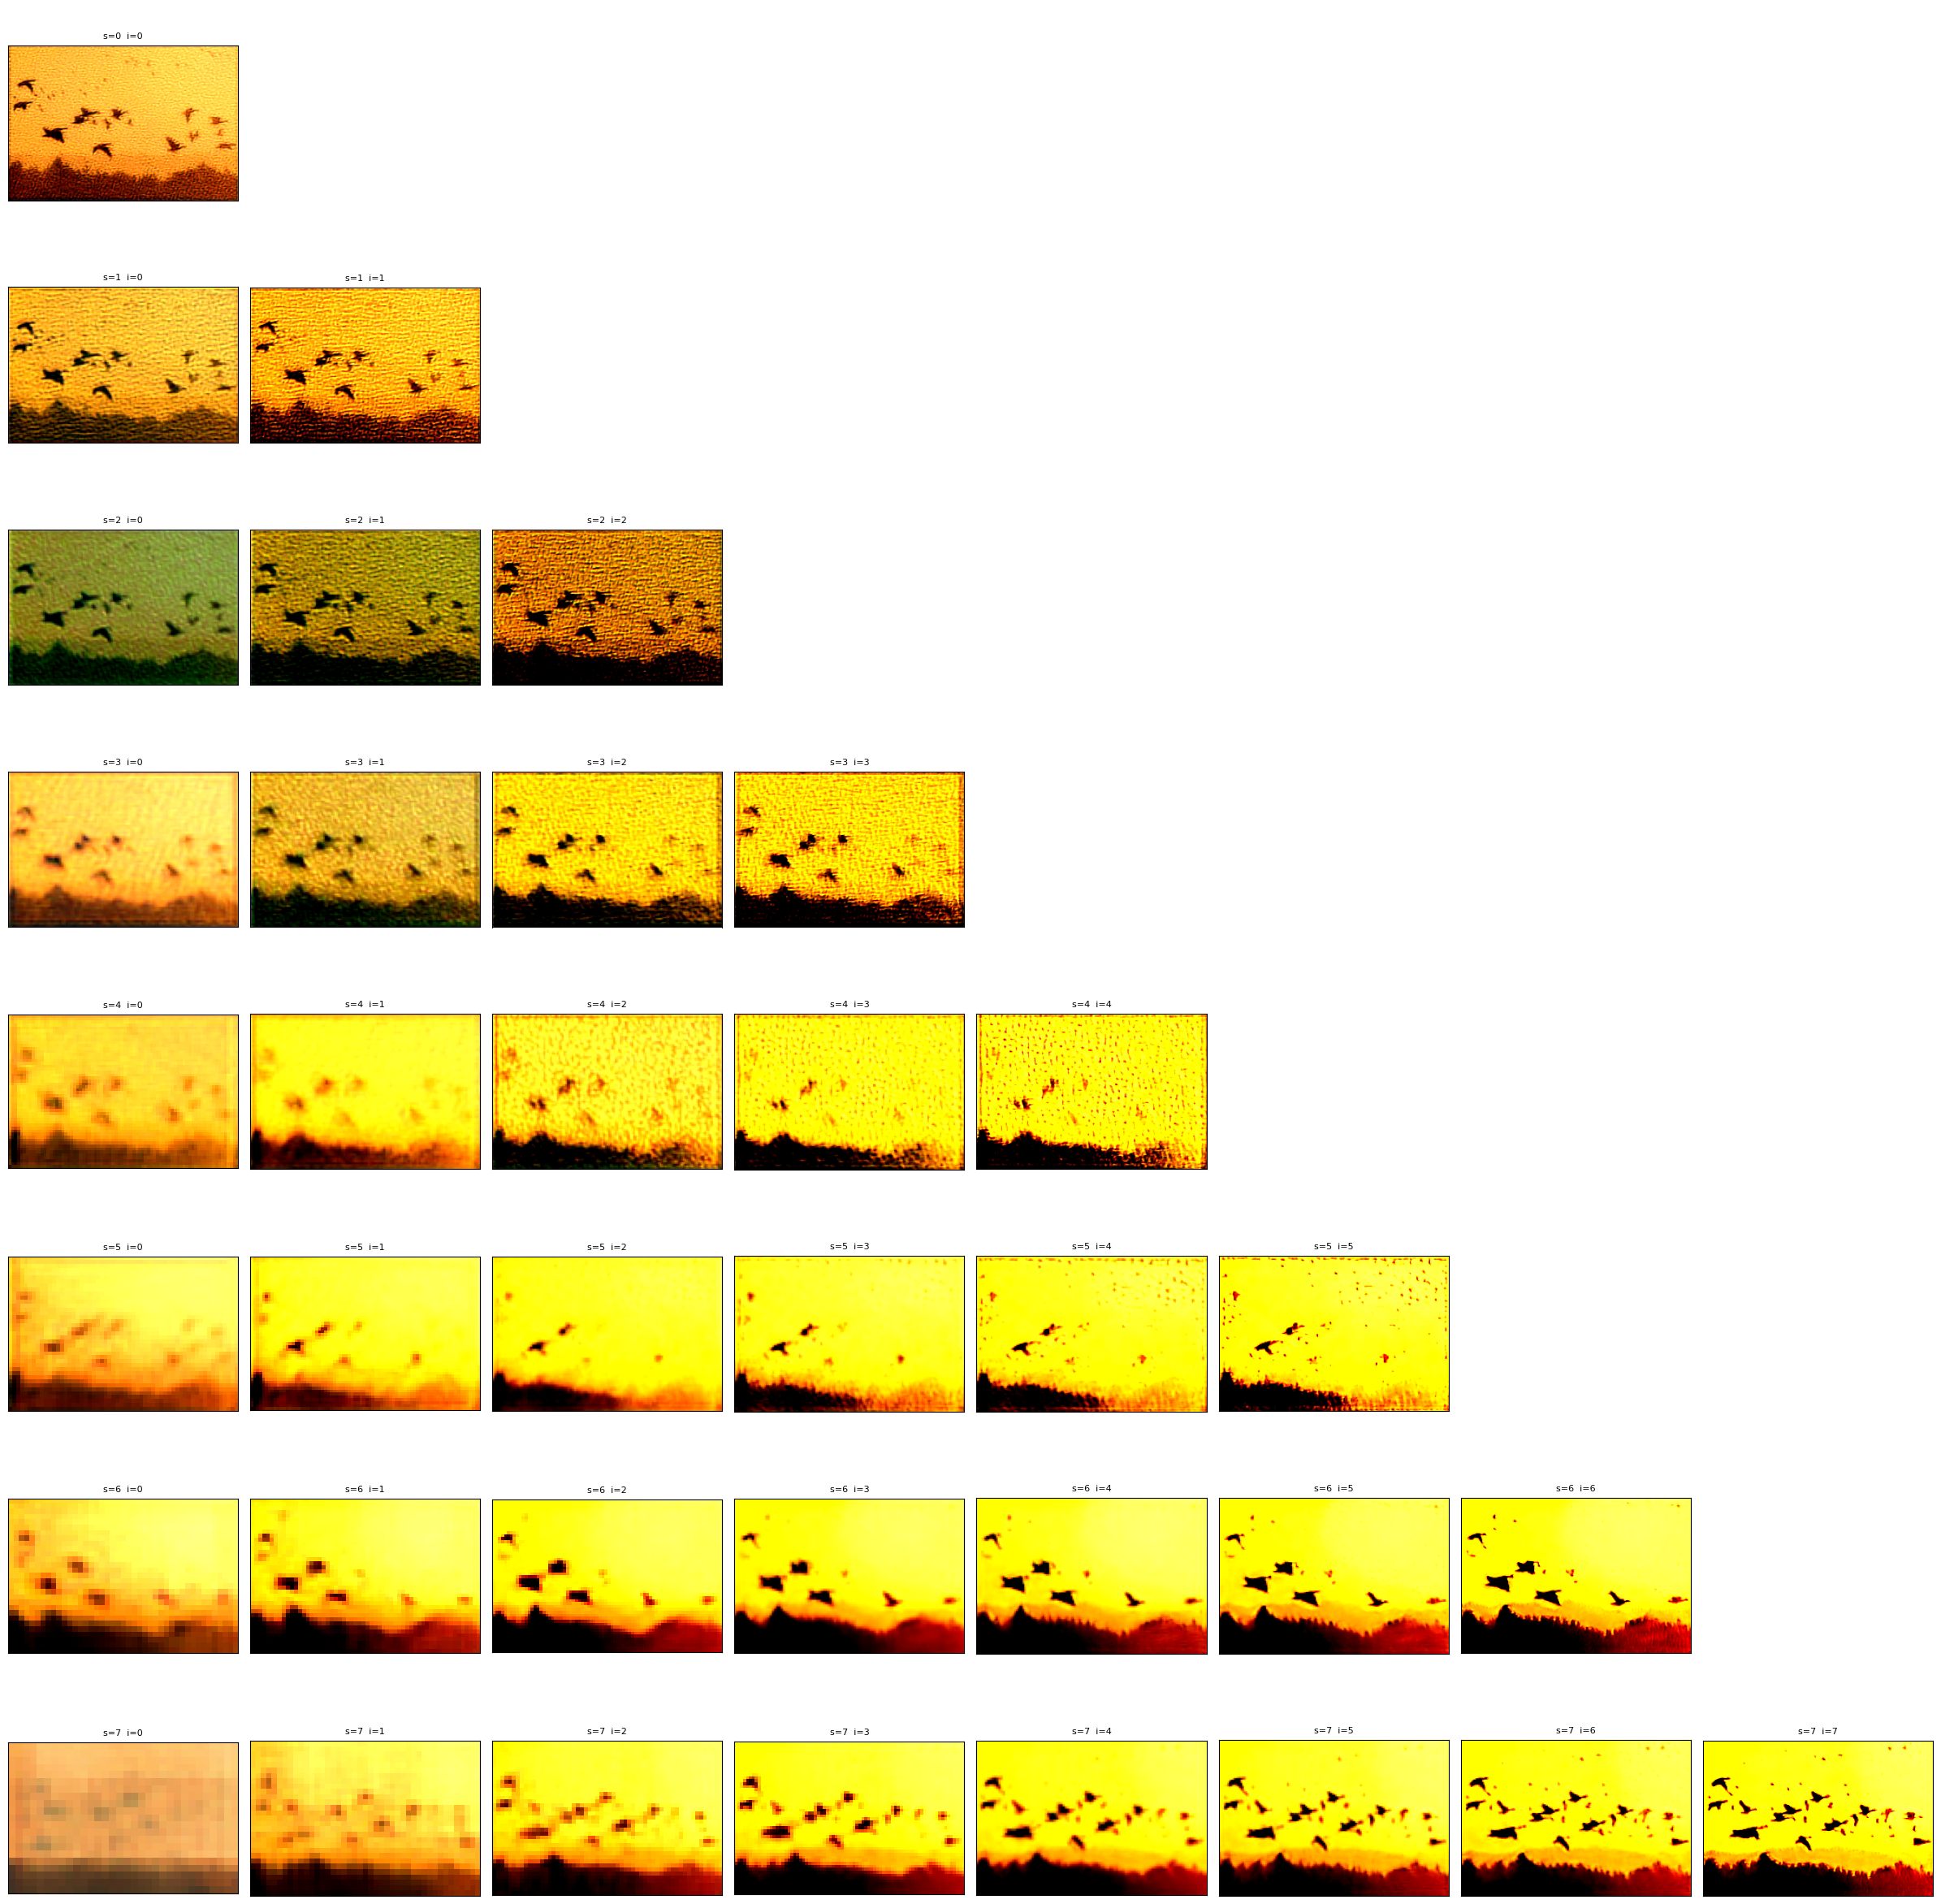

In [46]:
# 1. Collecter toutes les images pour connaître la taille de la grille
rows      = []                 # liste des listes d’images (Tensor)
max_cols  = 0
for s in range(N):
    imgs = generate_multiscale(start_scale=s,Generators=loaded_generators)   # list[Tensor]
    rows.append(imgs)
    max_cols = max(max_cols, len(imgs))

# 2. Créer la figure
cell = 3.0                     # taille (pouces) d’une cellule
fig_w, fig_h = cell * max_cols, cell * N
fig, axes = plt.subplots(N, max_cols, figsize=(fig_w, fig_h), squeeze=False)

# 3. Remplir le tableau
for r, (s, imgs) in enumerate(zip(range(N), rows)):
    for c in range(max_cols):
        ax = axes[r, c]

        if c < len(imgs):
            img_pil = pil_from_minus1to1(imgs[c].cpu().squeeze())
            
            ax.imshow(img_pil)
            ax.set_title(f"s={s}  i={c}", fontsize=8)
        else:
            ax.axis('off')          # cellule vide

        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

saved → models/no_recloss/outputs/gen_20250526_212424_1.png
saved → models/no_recloss/outputs/gen_20250526_212424_2.png
saved → models/no_recloss/outputs/gen_20250526_212424_3.png
saved → models/no_recloss/outputs/gen_20250526_212424_4.png
saved → models/no_recloss/outputs/gen_20250526_212424_5.png
saved → models/no_recloss/outputs/gen_20250526_212425_6.png
saved → models/no_recloss/outputs/gen_20250526_212425_7.png
saved → models/no_recloss/outputs/gen_20250526_212425_8.png


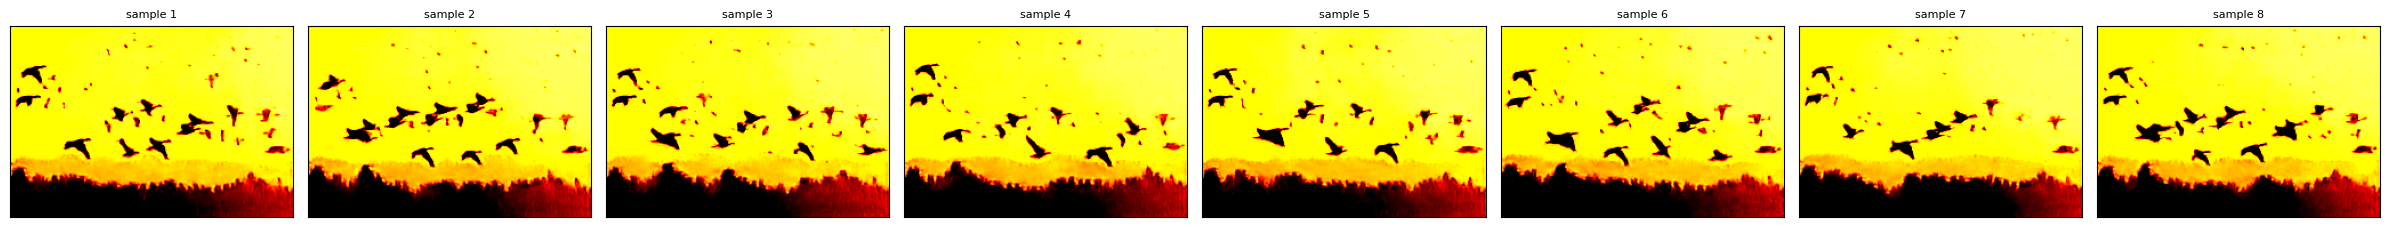

In [47]:
import torchvision.utils as vutils
import os, time

# dossier de sortie
out_dir = "models/no_recloss/outputs"
os.makedirs(out_dir, exist_ok=True)

# Nombre de générations
K = 8
final_imgs = []
for k in range(K):
    imgs = generate_multiscale(start_scale=N-1,Generators=loaded_generators)
    final_imgs.append(imgs[-1].cpu().squeeze())      # dernière image

# affichage + sauvegarde
cell = 3.0
fig, axes = plt.subplots(1, K, figsize=(cell*K, cell), squeeze=False)

for idx, (ax, img) in enumerate(zip(axes[0], final_imgs), 1):
    # plot
    ax.imshow(pil_from_minus1to1(img))
    ax.set_title(f"sample {idx}", fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

    # sauvegarde
    img_01 = ((img.clamp(-1, 1) + 1) / 2)            # [-1,1] → [0,1]
    filename = os.path.join(
        out_dir, f"gen_{time.strftime('%Y%m%d_%H%M%S')}_{idx}.png"
    )
    vutils.save_image(img_01, filename)
    print(f"saved → {filename}")

plt.tight_layout()
plt.show()


Reconstruction de XREC

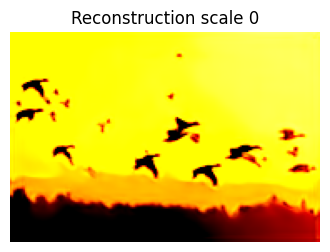

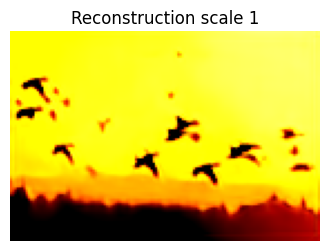

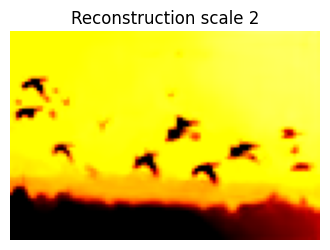

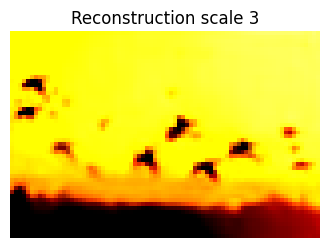

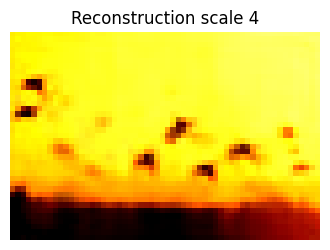

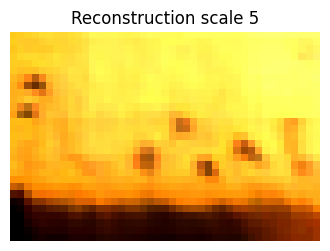

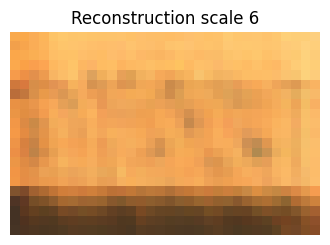

In [48]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec, scales):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:],scales)